In [1]:
# Mount Drive and set up
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted"
KEEP = "ERR13137440"  # single sample
!mkdir -p "{BASE}/data/raw" "{BASE}/data/processed" "{BASE}/refs" "{BASE}/align" "{BASE}/isoforms" "{BASE}/results" "{BASE}/workflow/outputs"
%env BASE={BASE}
%env KEEP={KEEP}

!echo $BASE && ls -R "$BASE"

Mounted at /content/drive
env: BASE=/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted
env: KEEP=ERR13137440
/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted
/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted:
align  data  isoforms  qc  refs  results  workflow

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/align:
ERR13137440.bam  ERR13137440.bam.bai

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/data:
processed  raw

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/data/processed:
mini_ERR13137440.fastq.gz

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/data/raw:
ERR13137440.fastq.gz

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms:
ERR13137440

/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440:
e2t.ctab	     ERR13137440.guided.gtf		i_data.ctab
e_data.ctab	     ERR13137440.transcripts.bed	t_data.ctab
ERR13137440.gtf    

In [2]:
%%bash
# Install tools (once per runtime)
apt-get -qq update
apt-get -qq install -y minimap2 samtools bedtools seqtk gffread stringtie

Selecting previously unselected package bedtools.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../0-bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Selecting previously unselected package libgclib3:amd64.
Preparing to unpack .../1-libgclib3_0.12.7+ds-4_amd64.deb ...
Unpacking libgclib3:amd64 (0.12.7+ds-4) ...
Selecting previously unselected package gffread.
Preparing to unpack .../2-gffread_0.12.7-2build1_amd64.deb ...
Unpacking gffread (0.12.7-2build1) ...
Selecting previously unselected package libhtscodecs2:amd64.
Preparing to unpack .../3-libhtscodecs2_1.1.1-3_amd64.deb ...
Unpacking libhtscodecs2:amd64 (1.1.1-3) ...
Selecting previously unselected package libhts3:amd64.
Preparing to unpack .../4-libhts3_1.13+ds-2build1_amd64.deb ...
Unpacking libhts3:amd64 (1.13+ds-2build1) ...
Selecting previously unselected package minimap2.
Preparing to unpack .../5-minimap2_2.24+dfsg-2_amd64.deb ...


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
%%bash
# subsample one raw FASTQ to <1GB
BASE="${BASE}"; KEEP="${KEEP}"
RAW="$BASE/data/raw"; PROC="$BASE/data/processed"; NREADS=300000
if [ -s "$RAW/${KEEP}.fastq.gz" ]; then
  seqtk sample -s100 "$RAW/${KEEP}.fastq.gz" "$NREADS" | gzip -c > "$PROC/mini_${KEEP}.fastq.gz"
fi
ls -lh "$PROC" || true

In [ ]:
# Build refs (GRCh38, GENCODE v46) and 28-gene BED
import os, re, shutil, gzip, urllib.request

BASE = os.environ["BASE"]; REF=f"{BASE}/refs"
os.makedirs(REF, exist_ok=True)
fa_gz="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/GRCh38.primary_assembly.genome.fa.gz"
gtf_gz="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.annotation.gtf.gz"
fa=f"{REF}/GRCh38.primary_assembly.genome.fa"
gtf=f"{REF}/gencode.v46.annotation.gtf"

def fetch_gz(url, out_plain):
    if not os.path.exists(out_plain):
        gz = out_plain + ".gz"
        urllib.request.urlretrieve(url, gz)
        with gzip.open(gz,'rb') as fin, open(out_plain,'wb') as fout: shutil.copyfileobj(fin,fout)

fetch_gz(fa_gz, fa)
fetch_gz(gtf_gz, gtf)

panel_txt=f"{REF}/panel28_genes.txt"
with open(panel_txt,"w") as f:
    f.write("\n".join([
      "BRCA1","BRCA2","ATM","ATR","BARD1","BRIP1","CDH1","CHEK2","MRE11","NBN","PALB2","PTEN",
      "RAD50","RAD51","RAD51C","RAD51D","RECQL","TP53","XRCC2","XRCC3","FANCA","FANCC","FANCM",
      "MSH2","MSH6","MLH1","PMS2","EPCAM"
    ])+"\n")

raw_bed=f"{REF}/panel28_genes.raw.bed"
bed_bed=f"{REF}/panel28_genes.bed"
genes=set(x.strip() for x in open(panel_txt) if x.strip())
n=0
with open(gtf) as fin, open(raw_bed,"w") as fout:
    for line in fin:
        if not line or line[0]=="#": continue
        parts=line.rstrip("\n").split("\t")
        if len(parts)<9 or parts[2]!="gene": continue
        m=re.search(r'gene_name "([^"]+)"', parts[8])
        if not m: continue
        name=m.group(1)
        if name in genes:
            chrom=parts[0]; start=int(parts[3])-1; end=int(parts[4]); strand=parts[6]
            fout.write(f"{chrom}\t{start}\t{end}\t{name}\t.\t{strand}\n")
            n+=1
shutil.copy(raw_bed, bed_bed)
print("panel28 genes BED rows:", n)

In [4]:
%%bash
# Map (minimap2) if BAM absent; else skip
BASE="${BASE}"; KEEP="${KEEP}"
PROC="$BASE/data/processed"; ALN="$BASE/align"; REF="$BASE/refs"
FA="$REF/GRCh38.primary_assembly.genome.fa"

if [ -s "$ALN/${KEEP}.bam" ]; then
  echo "[INFO] BAM exists: $ALN/${KEEP}.bam"
else
  fq="$PROC/mini_${KEEP}.fastq.gz"
  if [ -s "$fq" ]; then
    minimap2 -t 4 -ax splice -uf -k14 "$FA" "$fq" | samtools sort -m 1G -@2 -o "$ALN/${KEEP}.bam" -
    samtools index "$ALN/${KEEP}.bam"
  else
    echo "[WARN] Missing $fq — provide subsampled FASTQ or skip to annotation if BAM exists."
  fi
fi
ls -lh "$ALN" || true

[INFO] BAM exists: /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/align/ERR13137440.bam
total 2.6G
-rw------- 1 root root 2.6G Aug 28 17:38 ERR13137440.bam
-rw------- 1 root root 2.5M Aug 28 23:20 ERR13137440.bam.bai


In [5]:
%%bash
# Annotate (StringTie) and make transcript BED (Python)
BASE="${BASE}"; KEEP="${KEEP}"
ALN="$BASE/align"; ISO="$BASE/isoforms"; RES="$BASE/results"; REF="$BASE/refs"
GTF="$REF/gencode.v46.annotation.gtf"

bam="$ALN/${KEEP}.bam"; mkdir -p "$ISO/$KEEP" "$RES"
[ -s "$bam" ] || { echo "[ERR] BAM missing: $bam"; exit 1; }

stringtie -L -G "$GTF" -o "$ISO/$KEEP/${KEEP}.gtf" "$bam"
stringtie -e -B -G "$GTF" -o "$ISO/$KEEP/${KEEP}.guided.gtf" "$bam"
gffread -E "$ISO/$KEEP/${KEEP}.gtf" -T -o "$ISO/$KEEP/${KEEP}.gtf.tmp"

python - <<'PY'
import os, re
BASE=os.environ["BASE"]; KEEP=os.environ["KEEP"]
gtf=f"{BASE}/isoforms/{KEEP}/{KEEP}.gtf.tmp"
bed=f"{BASE}/isoforms/{KEEP}/{KEEP}.transcripts.bed"
n=0
with open(gtf) as fin, open(bed,"w") as fout:
    for ln in fin:
        if not ln or ln[0]=="#": continue
        f=ln.rstrip("\n").split("\t")
        if len(f)<9 or f[2]!="transcript": continue
        m=re.search(r'transcript_id "([^"]+)"', f[8])
        tid=m.group(1) if m else "NA"
        chrom=f[0]; start=str(int(f[3])-1); end=f[4]; strand=f[6]
        fout.write("\t".join([chrom,start,end,tid,".",strand])+"\n")
        n+=1
print("transcript BED rows:", n)
PY

# quick global counts
echo -n > "$RES/isoform_counts.tsv"
n_all=$(grep -c $'\ttranscript\t' "$ISO/$KEEP/${KEEP}.gtf.tmp" || true)
echo -e "${KEEP}\t${n_all}\t0" >> "$RES/isoform_counts.tsv"  # panel filled in next cell
cat "$RES/isoform_counts.tsv"

transcript BED rows: 26350
ERR13137440	26350	0


Command line was:
gffread -E /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.gtf -T -o /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.gtf.tmp
   .. loaded 26350 genomic features from /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.gtf


In [6]:
%%bash
# Intersect with 28-gene panel BED and per-gene counts
BASE="${BASE}"; KEEP="${KEEP}"
ISO="$BASE/isoforms"; RES="$BASE/results"; REF="$BASE/refs"
PANELBED="$REF/panel28_genes.bed"

bedtools intersect -s -wa -wb -a "$ISO/$KEEP/${KEEP}.transcripts.bed" -b "$PANELBED" \
  > "$ISO/$KEEP/${KEEP}.transcripts.panel.bed"

# Update isoform_counts.tsv with panel hits
n_panel=$(wc -l < "$ISO/$KEEP/${KEEP}.transcripts.panel.bed" || echo 0)
awk -v OFS="\t" -v S="$KEEP" -v P="$n_panel" '{ if ($1==S && NR==1) {print $1,$2,P} else if (NR==1) {print} }' "$RES/isoform_counts.tsv" > "$RES/.tmp" || echo -e "$KEEP\t0\t$P" > "$RES/.tmp"
mv "$RES/.tmp" "$RES/isoform_counts.tsv"

# Make per-gene table: sample, gene, count
: > "$RES/panel_gene_hits.tsv"
bedtools intersect -s -wa -wb -a "$ISO/$KEEP/${KEEP}.transcripts.bed" -b "$PANELBED" \
 | awk -v S="$KEEP" 'BEGIN{FS=OFS="\t"}{print S,$10,$4}' \
 | sort | uniq -c \
 | awk 'BEGIN{OFS="\t"}{print $2,$3,$1}' >> "$RES/panel_gene_hits.tsv"

echo "[RESULTS]"; cat "$RES/isoform_counts.tsv"
echo "[GENE-HIT HEAD]"; head -n 15 "$RES/panel_gene_hits.tsv" || true

[RESULTS]
ERR13137440	26350	276
[GENE-HIT HEAD]
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1
ERR13137440	ATM	1


***** WARNING: File /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.transcripts.bed has inconsistent naming convention for record:
GL000194.1	93088	97607	STRG.20239.1	.	-

***** WARNING: File /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.transcripts.bed has inconsistent naming convention for record:
GL000194.1	93088	97607	STRG.20239.1	.	-

***** WARNING: File /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.transcripts.bed has inconsistent naming convention for record:
GL000194.1	93088	97607	STRG.20239.1	.	-

***** WARNING: File /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/isoforms/ERR13137440/ERR13137440.transcripts.bed has inconsistent naming convention for record:
GL000194.1	93088	97607	STRG.20239.1	.	-



Top 10 genes:
   gene  count
   ATM     37
  MLH1     23
 RAD50     22
 BRCA1     21
 RAD51     17
 PALB2     16
RAD51C     16
   NBN     15
  PTEN     14
 CHEK2     12


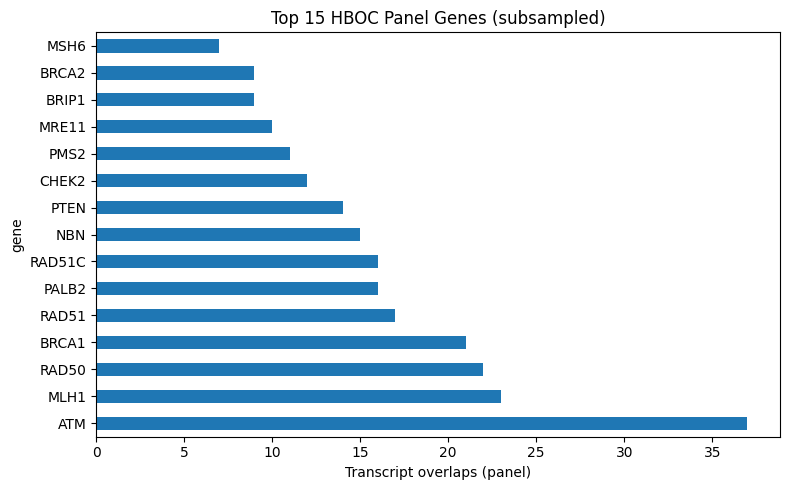

saved: /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/results/top_panel_genes.png


In [7]:
# Plot top genes and save PNG
import os, pandas as pd, matplotlib.pyplot as plt

BASE=os.environ["BASE"]
tsv=os.path.join(BASE,"results","panel_gene_hits.tsv")
df=pd.read_csv(tsv, sep="\t", header=None, names=["sample","gene","count"], dtype=str)
df["count"]=pd.to_numeric(df["count"], errors="coerce")
df=df.dropna(subset=["count"])
summary=df.groupby("gene", as_index=False)["count"].sum().sort_values("count", ascending=False)

print("Top 10 genes:\n", summary.head(10).to_string(index=False))

top15=summary.head(15).set_index("gene")
plt.figure(figsize=(8,5))
top15["count"].plot(kind="barh")
plt.xlabel("Transcript overlaps (panel)")
plt.title("Top 15 HBOC Panel Genes (subsampled)")
plt.tight_layout()
out=os.path.join(BASE,"results","top_panel_genes.png")
plt.savefig(out, dpi=160, bbox_inches="tight")
plt.show()
print("saved:", out)

In [8]:
%%bash
# OPTIONAL: convert BAM→CRAM to shrink storage
BASE="${BASE}"; KEEP="${KEEP}"
ALN="$BASE/align"; REF="$BASE/refs/GRCh38.primary_assembly.genome.fa"
bam="$ALN/${KEEP}.bam"
if [ -s "$bam" ]; then
  cram="${bam%.bam}.cram"
  samtools view -T "$REF" -C -o "$cram" "$bam"
  samtools index "$cram"
  rm -f "$bam" "$bam.bai"
fi
ls -lh "$ALN" || true

total 1.6G
-rw------- 1 root root 1.6G Aug 29 18:38 ERR13137440.cram
-rw------- 1 root root  13K Aug 29 18:38 ERR13137440.cram.crai


In [9]:
# write questions.yaml
import os, textwrap

BASE = os.environ.get("BASE", "/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted")
qs_path = os.path.join(BASE, "questions.yaml")

questions_yaml = textwrap.dedent("""\
task: >
  You have been given a subsampled long-read RNA-seq dataset (ERR13137440).
  Using the processed FASTQ/BAM and panel-intersect outputs in results/, answer the following:

questions:
- id: q1_total_isoforms
  stage: isoform_assembly
  text: How many total transcripts were assembled from ERR13137440?
  answer_type: integer_exact

- id: q2_panel_isoforms
  stage: panel_intersection
  text: How many transcripts overlapped the 28-gene HBOC panel?
  answer_type: integer_exact

- id: q3_top_gene
  stage: gene_summary
  text: Which panel gene had the highest transcript overlap count?
  answer_type: string_exact

- id: q4_brca1_vs_brca2
  stage: gene_comparison
  text: What is the transcript count ratio BRCA1/BRCA2?
  answer_type: numeric_float
  tolerance: 0.01

- id: q5_top3_genes
  stage: visualization
  text: According to panel_gene_hits.tsv, what are the top 3 genes by count?
  answer_type: list_string
""")

os.makedirs(BASE, exist_ok=True)
with open(qs_path, "w") as f:
    f.write(questions_yaml)
print(f"[OK] wrote {qs_path}")
print(open(qs_path).read())

[OK] wrote /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/questions.yaml
task: >
  You have been given a subsampled long-read RNA-seq dataset (ERR13137440).
  Using the processed FASTQ/BAM and panel-intersect outputs in results/, answer the following:

questions:
- id: q1_total_isoforms
  stage: isoform_assembly
  text: How many total transcripts were assembled from ERR13137440?
  answer_type: integer_exact

- id: q2_panel_isoforms
  stage: panel_intersection
  text: How many transcripts overlapped the 28-gene HBOC panel?
  answer_type: integer_exact

- id: q3_top_gene
  stage: gene_summary
  text: Which panel gene had the highest transcript overlap count?
  answer_type: string_exact

- id: q4_brca1_vs_brca2
  stage: gene_comparison
  text: What is the transcript count ratio BRCA1/BRCA2?
  answer_type: numeric_float
  tolerance: 0.01

- id: q5_top3_genes
  stage: visualization
  text: According to panel_gene_hits.tsv, what are the top 3 genes by count?
  answer_type: l

In [10]:
# compute answers from current outputs and write answers.yaml
import os, pandas as pd, math, yaml

BASE = os.environ.get("BASE", "/content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted")
iso_tsv = os.path.join(BASE, "results", "isoform_counts.tsv")
hits_tsv = os.path.join(BASE, "results", "panel_gene_hits.tsv")
ans_path = os.path.join(BASE, "answers.yaml")

# q1 & q2 from isoform_counts.tsv: columns = sample, total_isoforms, panel_hits
iso = pd.read_csv(iso_tsv, sep="\t", header=None, names=["sample","total","panel"])
q1_total_isoforms = int(iso.loc[0, "total"])
q2_panel_isoforms = int(iso.loc[0, "panel"])

# Aggregate per gene from panel_gene_hits.tsv: columns = sample, gene, count
hits = pd.read_csv(hits_tsv, sep="\t", header=None, names=["sample","gene","count"])
hits["count"] = pd.to_numeric(hits["count"], errors="coerce").fillna(0).astype(int)
gene_sum = hits.groupby("gene", as_index=True)["count"].sum().sort_values(ascending=False)

q3_top_gene = str(gene_sum.index[0]) if not gene_sum.empty else ""

brca1 = int(gene_sum.get("BRCA1", 0))
brca2 = int(gene_sum.get("BRCA2", 0))
q4_brca1_vs_brca2 = float(brca1)/float(brca2) if brca2 != 0 else float("inf")

top3 = list(gene_sum.head(3).index)
answers = {
    "q1_total_isoforms": int(q1_total_isoforms),
    "q2_panel_isoforms": int(q2_panel_isoforms),
    "q3_top_gene": q3_top_gene,
    "q4_brca1_vs_brca2": None if math.isinf(q4_brca1_vs_brca2) else round(q4_brca1_vs_brca2, 2),
    "q5_top3_genes": top3,
}

with open(ans_path, "w") as f:
    yaml.safe_dump(answers, f, sort_keys=False)

print(f"[OK] wrote {ans_path}")
print(open(ans_path).read())

[OK] wrote /content/drive/MyDrive/brca-targeted-analysis/brca_rna_targeted/answers.yaml
q1_total_isoforms: 26350
q2_panel_isoforms: 276
q3_top_gene: ATM
q4_brca1_vs_brca2: 2.33
q5_top3_genes:
- ATM
- MLH1
- RAD50

